In [1]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
import argparse
import os 
import os.path as osp
from darknet import Darknet
from preprocess import prep_image, inp_to_image
import pandas as pd
import random 
import pickle as pkl
import itertools
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
CUDA = torch.cuda.is_available()
num_classes = 80
classes = load_classes('data/coco.names') 
colors = pkl.load(open("pallete", "rb"))

In [3]:
print("Loading network.....")
model = Darknet('cfg/yolov3.cfg')
model.load_weights('yolov3.weights')
model.eval()
if CUDA:
    model.cuda()
print("Network successfully loaded")

inp_dim = int(model.net_info["height"])

Loading network.....
Network successfully loaded


In [4]:
batches = list(prep_image("img.jpg", inp_dim))

im_batches = [batches[0]]
orig_ims = [batches[1]]
im_dim_list = [batches[2]]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)

if CUDA:
    im_dim_list = im_dim_list.cuda()

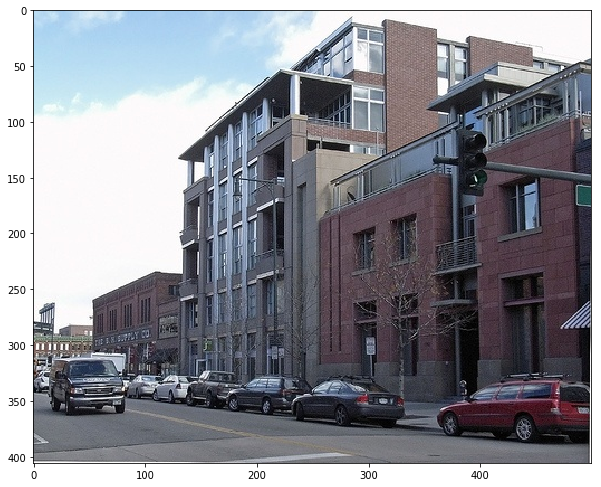

In [5]:
plt.figure(figsize = (10, 10))
img_rgb = cv2.cvtColor(orig_ims[0], cv2.COLOR_BGR2RGB)
imshow(img_rgb)

In [6]:
# run images through neural network
def get_predictions(im_batches, confidence, nms_thresh):
    output = None
    for batch in im_batches:
        if CUDA:
            batch = batch.cuda()
            
        with torch.no_grad():
            prediction = model(Variable(batch), CUDA)
        prediction = write_results(prediction, confidence, num_classes, nms=True, nms_conf=nms_thresh)

        if output is None:
            output = prediction
        else:
            output = torch.cat((output, prediction))
            
    return output

            
# scale back outputs to fit original image
def scale_predictions(output, im_dim_list, inp_dim):
    im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())
    scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)

    output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
    output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2
    output[:,1:5] /= scaling_factor
    for i in range(output.shape[0]):
        output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
        output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
        
    return output


# draw bounding boxes on original image
def write(x, batches, results):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img

/home/tliu/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


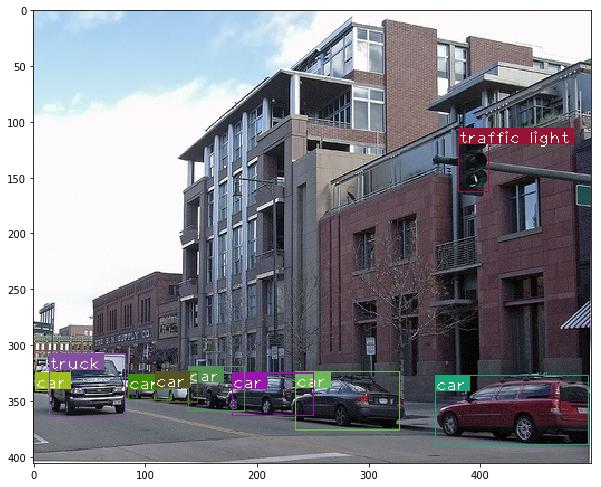

In [7]:
# TODO
confidence=0.5
nms_thresh=0.4

output = get_predictions(im_batches, confidence, nms_thresh)      
output = scale_predictions(output, im_dim_list, inp_dim)
list(map(lambda x: write(x, im_batches, orig_ims), output))

plt.figure(figsize = (10, 10))
img_rgb = cv2.cvtColor(orig_ims[0], cv2.COLOR_BGR2RGB)
imshow(img_rgb)